# Comparison of Custom Numpy, PyTorch and TensorFlow

In [231]:
import numpy as np
import matplotlib.pyplot as plt
import idx2numpy
import random
from urllib import request
import shutil
import gzip
import os
from tqdm import tqdm

# Prepare the Dataset

### Download and unzip the MNIST dataset

In [232]:
base_url = 'http://yann.lecun.com/exdb/mnist/'

dataset = ['train-images.idx3-ubyte', 'train-labels.idx1-ubyte',
           't10k-images.idx3-ubyte', 't10k-labels.idx1-ubyte']

for file in dataset:
    
    _file = file.replace('.', '-') + '.gz'
    
    if _file not in os.listdir():
        with request.urlopen(f'{base_url}{_file}') as response, open(_file, 'wb') as out_file:
            shutil.copyfileobj(response, out_file)
    
    if file not in os.listdir():
        with gzip.open(_file, 'rb') as f_in, open(file, 'wb') as f_out:
            shutil.copyfileobj(f_in, f_out)

### Load the dataset and normalize

In [233]:
train_images = idx2numpy.convert_from_file(dataset[0]) / 255.0
train_labels = idx2numpy.convert_from_file(dataset[1])
test_images  = idx2numpy.convert_from_file(dataset[2]) / 255.0
test_labels  = idx2numpy.convert_from_file(dataset[3])

### Plot a random sample

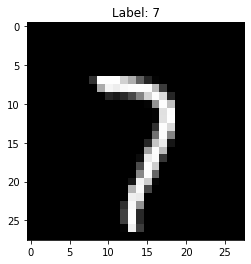

In [234]:
idx = random.randint(0, len(train_images))
plt.title(f'Label: {train_labels[idx]}')
plt.imshow(train_images[idx], cmap='gray')

### Define the common parameters

In [235]:
EPOCHS = 20
LR = 0.01

# Numpy Implementation

In [236]:
DTYPE = np.float32

### Define the required functions

In [237]:
def label_to_onehot(index, num_of_classes=10):
    label = np.zeros((1, num_of_classes))
    label[0][index] = 1
    return label

In [238]:
def relu(vector):
    vector[vector<0] = 0
    return vector

In [239]:
def relu_derivative(vector):
    vector[vector<=0] = 0.0
    vector[vector>0] = 1.0
    return vector

In [240]:
def softmax(vector):
    exp = np.exp(vector - np.max(vector))
    return exp / exp.sum()

In [241]:
def cross_entropy(predict, label):
    return -np.sum(label*np.log(predict)).astype(DTYPE)

In [242]:
def cross_entropy_derivative(predict, label):
    return (-label/predict).astype(DTYPE)

In [243]:
def softmax_derivative(softmax):
    s = softmax.reshape(-1,1)
    return np.diagflat(s) - np.dot(s, s.T)

### Declare the Custom Numpy Model

In [244]:
class CustomMnist:
    
    def __init__(self, input_shape=(28, 28)):
        
        input_shape = input_shape[0]*input_shape[1]
        self.layer1 = np.random.uniform(-1.0, 1.0, size=(input_shape, 128))/np.sqrt(input_shape*128)
        self.layer2 = np.random.uniform(-1.0, 1.0, size=(128, 10))/np.sqrt(128*10)
        
        self.bias1 = np.random.uniform(-1.0, 1.0, size=(1, 128))/np.sqrt(128)
        self.bias2 = np.random.uniform(-1.0, 1.0, size=(1, 10))/np.sqrt(10)
        
        self.layer1 = self.layer1.astype(DTYPE)
        self.layer2 = self.layer2.astype(DTYPE)
        self.bias1 = self.bias1.astype(DTYPE)
        self.bias2 = self.bias2.astype(DTYPE)
        
    def forward(self, image):
        
        self.flatten = np.reshape(image.astype(DTYPE), (1, image.shape[0]*image.shape[1]))
        self.inter1 = np.dot(self.flatten, self.layer1) + self.bias1
        self.acti1 = relu(self.inter1)
        self.inter2 = np.dot(self.acti1, self.layer2) + self.bias2
        self.acti2 = softmax(self.inter2)
        
        return self.acti2
    
    def backward(self, label):
        
        temp1 = np.dot(self.layer2, label.T)
        temp2 = np.dot(self.layer1, temp1)
        temp2 = np.resize(temp2, (28, 28))
        
        return temp2
        
    def back_propagation(self, label):
        
        d_cross_entropy = cross_entropy_derivative(self.acti2, label)        
        self.d_softmax = np.dot(d_cross_entropy, softmax_derivative(self.acti2))
        self.d_layer2 = np.dot(self.acti1.T, self.d_softmax)
        d_acti1 = np.dot(self.d_softmax, self.layer2.T)
        self.d_relu = relu_derivative(self.acti1) * d_acti1
        self.d_layer1 = np.dot(self.flatten.T, self.d_relu)
        
    def optimize(self, lr):
        
        self.layer1 -= lr * self.d_layer1
        self.layer2 -= lr * self.d_layer2
        
        self.bias1 -= lr * self.d_relu
        self.bias2 -= lr * self.d_softmax
        
    def view(self):
        
        print('\nLayers\n----------------------------')
        print('Layer1: \t', self.layer1.shape)
        print('Layer2: \t', self.layer2.shape, end='\n\n')
        print('Flatten: \t', self.flatten.shape)
        print('Inter1: \t', self.inter1.shape)
        print('Acti1:  \t', self.acti1.shape)
        print('Inter2: \t', self.inter2.shape)
        print('Acti2:  \t', self.acti2.shape)

### Train the custom model

In [245]:
custom_mnist = CustomMnist()

losses, accuracies = list(), list()

for epoch in range(EPOCHS):
    
    b='{l_bar}{bar}| {n_fmt}/{total_fmt} [{elapsed}<{remaining}{postfix}]'
    pbar = tqdm(zip(train_images, train_labels),
                desc=f'Epochs: {epoch+1}/{EPOCHS}',
                total=len(train_images), ncols=80, bar_format=b)
    
    loss, accuracy = 0, 0
    for image, label in pbar:
        
        label = label_to_onehot(label)
        
        output = custom_mnist.forward(image)
        custom_loss = cross_entropy(output, label)
        custom_mnist.back_propagation(label)
        custom_mnist.optimize(lr=LR)
        
        loss += custom_loss
        if np.argmax(output) == np.argmax(label):
            accuracy += 1 
        
        pbar.set_postfix(Loss=f'{custom_loss:.4f}')
        
    losses.append(loss/len(train_images))
    accuracies.append(accuracy/len(train_images))

loss_plot = plt.plot(losses, label='loss')
acc_plot  = plt.plot(accuracies, label='accuracy')
plt.ylim(-0.1, 1.1)
plt.legend(loc='upper left')
plt.grid()

Epochs: 1/20:   1%|▏                      | 436/60000 [00:04<10:12, Loss=2.1367]


KeyboardInterrupt: 

### Evaluate the model

In [246]:
b='{l_bar}{bar}| {n_fmt}/{total_fmt} [{elapsed}<{remaining}{postfix}]'
pbar = tqdm(zip(test_images, test_labels),
            desc='Evaluating',
            total=len(test_images), ncols=80, bar_format=b)

accuracy = 0
for image, label in pbar:

    label = label_to_onehot(label)

    output = custom_mnist.forward(image)
    custom_loss = cross_entropy(output, label)
    
    if(np.argmax(output) == np.argmax(label)):
        accuracy += 1

    pbar.set_postfix(Loss=f'{custom_loss:.4f}')
    
print(f'Numpy model accuracy on test set: {(100*accuracy/len(test_labels)):.2f}%')

Evaluating: 100%|███████████████████████| 10000/10000 [01:09<00:00, Loss=1.9377]

Numpy model accuracy on test set: 47.97%


### Random test

Actual: 7, Predicted: 9


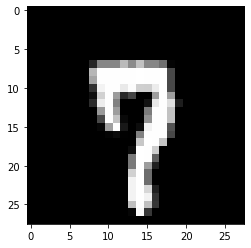

In [247]:
idx = random.randint(0, len(test_images))
forward = np.argmax(custom_mnist.forward(test_images[idx]))
print(f'Actual: {test_labels[idx]}, Predicted: {forward}')
plt.imshow(test_images[idx], cmap='gray')

### Backward pass

Actual: 1, Predicted: 1


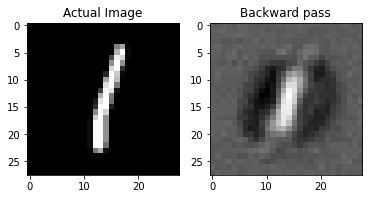

In [248]:
idx = random.randint(0, len(test_images))

label = label_to_onehot(test_labels[idx])
forward = np.argmax(custom_mnist.forward(test_images[idx]))
back = custom_mnist.backward(label)

print(f'Actual: {test_labels[idx]}, Predicted: {forward}')

fig, ax = plt.subplots(1, 2)
ax[0].set_title(f'Actual Image')
ax[1].set_title(f'Backward pass')
ax[0].imshow(test_images[idx], cmap='gray')
ax[1].imshow(back, cmap='gray')

# PyTorch Implementation

In [249]:
os.environ['CUDA_VISIBLE_DEVICES'] = ''
import torch
from torch.utils.data import TensorDataset, DataLoader
from torch import nn

### Load the dataset in torch

In [252]:
torch_train_images = torch.Tensor(np.copy(train_images))
torch_train_labels = torch.Tensor(np.copy(train_labels))

torch_train_dataset = TensorDataset(torch_train_images, torch_train_labels)
torch_train_dataloader = DataLoader(torch_train_dataset)

### Define the model, loss and optimizer

In [253]:
class TorchMnist(nn.Module):

    def __init__(self, input_shape=(28, 28)):
        super(TorchMnist, self).__init__()
        
        self.fc1 = nn.Linear(input_shape[0]*input_shape[1], 120)
        self.fc2 = nn.Linear(120, 10)

    def forward(self, x):
        
        x = torch.flatten(x)
        x = nn.functional.relu(self.fc1(x))
        x = nn.functional.softmax(self.fc2(x), dim=0)
        
        return x
    
torch_mnist = TorchMnist()
torch_loss = nn.CrossEntropyLoss()
torch_optimizer = torch.optim.SGD(torch_mnist.parameters(), lr=0.01)

### Train the model

In [255]:
for epoch in range(EPOCHS):
    
    b='{l_bar}{bar}| {n_fmt}/{total_fmt} [{elapsed}<{remaining}{postfix}]'
    pbar = tqdm(torch_train_dataloader,
                desc=f'Epochs: {epoch+1}/{EPOCHS}',
                total=len(train_images), ncols=80, bar_format=b)
    
    for image, label in pbar:
        
        torch_optimizer.zero_grad()
        
        output = torch_mnist(image).unsqueeze(0)        
        loss = torch_loss(output, label.type(torch.long))
        loss.backward()
        torch_optimizer.step()

        pbar.set_postfix(Loss=f'{loss:.4f}')

Epochs: 1/1:   7%|█▋                     | 4437/60000 [00:25<05:24, Loss=1.5702]


KeyboardInterrupt: 

### Load the testing data

In [256]:
torch_test_images = torch.Tensor(np.copy(test_images))
torch_test_labels = torch.Tensor(np.copy(test_labels))

torch_test_dataset = TensorDataset(torch_test_images, torch_test_labels)
torch_test_dataloader = DataLoader(torch_test_dataset)

### Evaluate the model

In [257]:
b='{l_bar}{bar}| {n_fmt}/{total_fmt} [{elapsed}<{remaining}{postfix}]'
pbar = tqdm(torch_test_dataloader,
            desc='Evaluating',
            total=len(test_images), ncols=80, bar_format=b)

accuracy = 0
for image, label in pbar:

    output = torch_mnist(image).unsqueeze(0)
    loss = torch_loss(output, label.type(torch.long))
    
    output = np.argmax(output.detach().numpy())
    
    if output == label:
        accuracy += 1

    pbar.set_postfix(Loss=f'{loss:.4f}') 
    
print(f'PyTorch model accuracy on test set: {(100*accuracy/len(test_labels)):.2f}%')

Evaluating: 100%|███████████████████████| 10000/10000 [00:43<00:00, Loss=1.4615]

PyTorch model accuracy on test set: 79.11%


### Random test

Actual: 6, Predicted: 6


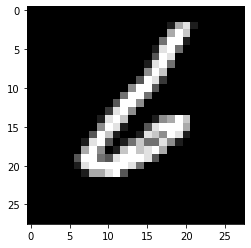

In [258]:
idx = random.randint(0, len(test_images))
forward = np.argmax(torch_mnist(image).unsqueeze(0).detach().numpy())
print(f'Actual: {test_labels[idx]}, Predicted: {forward}')
plt.imshow(test_images[idx], cmap='gray')

# TensorFlow Implementation

In [259]:
os.environ['CUDA_VISIBLE_DEVICES'] = ''
import tensorflow as tf 

### Load the data for training and testing

In [260]:
tf_train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels)).batch(1)
tf_test_dataset = tf.data.Dataset.from_tensor_slices((test_images, test_labels)).batch(1)

### Define and compile the model

In [261]:
tf_mnist = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])

tf_mnist.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=LR),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy']
)

### Train the model

In [262]:
tf_mnist.fit(tf_train_dataset, epochs=EPOCHS)

60000/60000 [==============================] - 115s 2ms/step - loss: 0.2101 - accuracy: 0.9376


Exception ignored in: <function IteratorResourceDeleter.__del__ at 0x7f0115e12310>
Traceback (most recent call last):
  File "/home/dinesh/projects/mnist_comparison/.env/lib/python3.9/site-packages/tensorflow/python/data/ops/iterator_ops.py", line 545, in __del__
    gen_dataset_ops.delete_iterator(
  File "/home/dinesh/projects/mnist_comparison/.env/lib/python3.9/site-packages/tensorflow/python/ops/gen_dataset_ops.py", line 1263, in delete_iterator
    _result = pywrap_tfe.TFE_Py_FastPathExecute(
KeyboardInterrupt: 


### Evaluate the model

In [ ]:
_, accuracy = tf_mnist.evaluate(tf_test_dataset)
print(f'TensorFlow model accuracy on test set: {(100*accuracy):.2f}%')

 2412/10000 [======>.......................] - ETA: 10s - loss: 0.1865 - accuracy: 0.9420

### Random test

In [ ]:
idx = random.randint(0, len(test_images))
forward = np.argmax(tf_mnist.predict(np.expand_dims(test_images[idx], axis=0)))
print(f'Actual: {test_labels[idx]}, Predicted: {forward}')
plt.imshow(test_images[idx], cmap='gray')